In [1]:
%reload_ext autoreload
%autoreload 2
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

from dmsensei import DataModule, create_model
from dmsensei.config import device
from dmsensei.core.callbacks import WandbFitLogger, KaggleLogger
from lightning.pytorch.callbacks import LearningRateMonitor
from lightning.pytorch import Trainer
from dmsensei.config import device
import sys
import os
from lightning.pytorch.loggers import WandbLogger
import torch, wandb
import numpy as np


# Create dataset
dm = DataModule(
    name=["ribo-valid", 'sarah_supermodel'],
    data_type=["dms", "shape"],
    force_download=False,
    batch_size=32,
    num_workers=0,
    train_split=256,
    valid_split=0,
    predict_split=0,
    overfit_mode=True,
    shuffle_valid=False,
)

dm.setup('fit')

Loading dataset from disk
Done!                            
Loading dataset from disk
Done!                            


In [2]:

import torch
import torch.nn.functional as F

lr = 5E-4
model = create_model(
    model="transformer",
    ntoken=5,
    d_model=64,
    nhead=16,
    d_hid=128,
    nlayers=2,
    dropout=0.0,
    lr=lr,
    weight_decay=0,
    gamma=0.997,
    c_z=8,
).to(device)

In [7]:
for epoch in range(100):
    for batch in dm.train_dataloader():
        print(f"epoch: {epoch}\tloss: {round(model.training_step(batch, 0).item(), 3)}\r", end="")

In [51]:
import torch
for batch in dm.train_dataloader():
    print(torch.unique(batch.get('structure')))
    break

tensor([-1000.,     0.,     1.], device='mps:0')


In [18]:
wandb.init(project="dmsensei", name='debug-structure')
trainer = Trainer(
    max_epochs=10000,
    callbacks=[
        WandbFitLogger(dm=dm)
    ],
    logger=WandbLogger(),
    )

trainer.fit(model, dm)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: yvesmartindestaillades (rouskin-lab). Use `wandb login --relogin` to force relogin


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/yvesmartin/.pyenv/versions/3.11.6/lib/python3.11/site-packages/lightning/pytorch/loggers/wandb.py:389: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.

  | Name                 | Type               | Params
------------------------------------------------------------
0 | encoder              | Embedding          | 320   
1 | pos_encoder          | PositionalEncoding | 0     
2 | encoder_adapter      | Linear             | 260   
3 | activ                | ReLU               | 0     
4 | transformer_encoder  | Sequential         | 66.9 K
5 | resnet               | Sequential         | 9.7 K 
6 | output_net_DMS       | Sequential         | 17.0 K
7 | output_net_SHAPE     | Sequential         | 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/yvesmartin/.pyenv/versions/3.11.6/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/yvesmartin/.pyenv/versions/3.11.6/lib/python3.11/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


In [ ]:
pred, true = batch.get_pairs('structure')

In [ ]:
%load_ext autoreload
%autoreload 2
from dmsensei import DataModule, Dataset
import envbash
envbash.load.load_envbash('.env')

In [ ]:
dataset = Dataset.from_local_or_download(
    'ribonanza',
)

Loading dataset from HF
Done!                            


In [ ]:
dataset2 = Dataset.from_local_or_download(
    'ribo-valid',
)

Loading dataset from disk
Done!                            


In [ ]:
d = dataset + dataset2

In [ ]:
d[0:100]

{'reference': array(['0000d87cab97', '00025186c1a8', '00026ef17e1b', '0003003cbb94',
        '000302908510', '00030bfc1545', '00039b2299a0', '0003f54c441b',
        '0003fd2531de', '0004c38463a3', '00053e0f1d27', '000680a98943',
        '000742b70d61', '000746fff280', '00075c42b441', '0007649b4eda',
        '0007772686b3', '00078729ee8d', '0007b6ed02fa', '00081b8cfdfd',
        '00086140a4ea', '00093bd72e9e', '00094f8838ad', '0009834c2421',
        '0009ba0e97b2', '000b5e69818f', '000c1aeb7e49', '000c83611c41',
        '000ca9c5e861', '000d314ee66c', '000d5378ae27', '000d75f3ed68',
        '000d8801d9e4', '000d960a19ca', '000d979a8199', '000dd8d73156',
        '000e148bd001', '000e1d84cc06', '000e3417937f', '000ec11b2e6c',
        '000f06c6118f', '000f588daf60', '000f7bed21d0', '001034b2634c',
        '00108bc7ae2f', '0010ac6acd0f', '0011287bf4f9', '00118b9c6705',
        '0011b5de1066', '0011d4dac70a', '0011da06149f', '001200fe942c',
        '001277b9bee4', '00128669b1f4', '0012a2f479

In [ ]:
d.collate_fn(d[0:32]).get('reference')

NameError: name 'd' is not defined

In [ ]:
dataset2[1:3]

{'reference': ['129c67583b99', '1d66f14b4ef9'],
 'sequence': ['GGGAACGACUCGAGUAGAGUCGAAAAGGGACGCCUUUAGAAGAAGAGGCUAGGUGGUAUUCCGGUGUGGGAUACUUGGUAAUAUGUAACGCUAAUUGCAUAAGAUUGUAGGACGGAAUUUACAGUCAUGACUUCGUUAAUUCGUUAACGAAGUCAUAAAAGAAACAACAACAACAAC',
  'GGGAACGACUCGAGUAGAGUCGAAAAGUGGAGGCGAAAGUCACCCUCCUCGCAUCGCAAGUUCGUGCUUGCGACUUACACGUAGGGCGAGGGGUGGGCGAAAGUUGCCAUGAGACCGUAACUUUCGGGGUGGAUAGUCAUUCGUGACUAUCCACCCAAAAGAAACAACAACAACAAC'],
 'length': [177, 177],
 'dms': {'true': [tensor([-1.0000e+03, -1.0000e+03, -1.0000e+03, -1.0000e+03, -1.0000e+03,
           -1.0000e+03, -1.0000e+03, -1.0000e+03, -1.0000e+03, -1.0000e+03,
           -1.0000e+03, -1.0000e+03, -1.0000e+03, -1.0000e+03, -1.0000e+03,
           -1.0000e+03, -1.0000e+03, -1.0000e+03, -1.0000e+03, -1.0000e+03,
           -1.0000e+03, -1.0000e+03, -1.0000e+03, -1.0000e+03, -1.0000e+03,
           -1.0000e+03, -1.0000e+03, -1.0000e+03, -1.0000e+03,  1.0000e+00,
            1.0000e+00, -1.0000e+03,  1.7600e-01,  7.9000e-02, -1.0000e+03,
   

In [ ]:
dataset2.collate_fn(dataset2[0:4]).get('shape')[2]

tensor([-1.0000e+03, -1.0000e+03, -1.0000e+03, -1.0000e+03, -1.0000e+03,
        -1.0000e+03, -1.0000e+03, -1.0000e+03, -1.0000e+03, -1.0000e+03,
        -1.0000e+03, -1.0000e+03, -1.0000e+03, -1.0000e+03, -1.0000e+03,
        -1.0000e+03, -1.0000e+03, -1.0000e+03, -1.0000e+03, -1.0000e+03,
        -1.0000e+03, -1.0000e+03, -1.0000e+03, -1.0000e+03, -1.0000e+03,
        -1.0000e+03,  6.4000e-01,  4.2700e-01,  4.2700e-01,  0.0000e+00,
         7.4700e-01,  4.1000e-01,  1.0000e+00,  4.2700e-01,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         2.1300e-01,  1.0000e+00,  5.8700e-01,  0.0000e+00,  2.6700e-01,
         1.0700e-01,  4.1000e-01,  2.1300e-01,  6.4000e-01,  1.0700e-01,
         2.6900e-01,  0.0000e+00,  1.0700e-01,  9.6100e-01,  1.0700e-01,
         6.4000e-01,  3.2000e-01,  1.0700e-01,  0.0000e+00,  0.0000e+00,
         1.0000e+00,  1.0000e+00,  9.6100e-01,  1.0000e+00,  1.0000e+00,
         3.2000e-01,  3.0300e-01,  0.0000e+00,  5.3

In [ ]:
import json

data = json.load(open('/Users/yvesmartin/src/DMSensei/data/ribo-valid/data.json'))


In [ ]:
b = [k for k, v in data.items() if not 'dms' in v.keys()]
b

['1d66f14b4ef9',
 '59328bd6247a',
 '8b7d8647a52a',
 'ff1c11ad267d',
 '567b21a8fddd',
 '078ac5257dca',
 'a3eac1817ddc',
 '18d0f028e833',
 '1a019894c89a',
 '863fd21d9803']

In [ ]:
import torch
a = [idx for idx in range(len(dataset2)) if None == dataset2[idx]['dms']['true']]

In [ ]:
a

[2, 5, 16, 95, 96, 111, 128, 185, 205, 475]

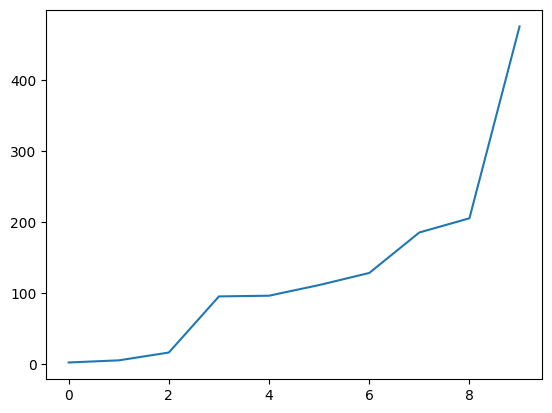

In [ ]:
import matplotlib.pyplot as plt

plt.plot(a)